# 04 - Evaluation Analysis

This notebook provides post-training evaluation and analysis of the fine-tuned Qwen2-VL model
for nutrition table detection.

**What this notebook covers:**
1. Load the fine-tuned model (with LoRA adapters)
2. Evaluate on the validation dataset using IoU metrics
3. Compare performance with the base model (no fine-tuning)
4. Visualize IoU distribution and predictions
5. Analyze failure cases

**Prerequisites:**
- Completed training (have saved LoRA adapters)
- `src/` modules installed (run from project root)

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '..')  # Add parent directory to path for src imports

# === GPU SETUP (MUST be before importing torch!) ===
from src.utils.gpu import setup_gpus
setup_gpus(use_dual_gpu=False, max_gpus=1)  # Single GPU is faster for evaluation

import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image

# Project imports
from src.training.evaluation import evaluate_model, print_evaluation_results, compare_models
from src.models.inference import parse_qwen_bbox_output
from src.utils.visualization import visualize_bbox_on_image, visualize_ground_truth_bbox
from src.utils.gpu import clear_memory

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

🖥️  AUTOMATIC GPU CONFIGURATION
Configuration: SINGLE GPU (test mode)
Looking for 1 available GPU(s) (max 1 to preserve lab resources)...
✅ Found 1 available GPU(s): [0]

CUDA_VISIBLE_DEVICES: 0
PyTorch sees 1 GPU(s):
  GPU 0: NVIDIA RTX 6000 Ada Generation (47.5 GB)

Total GPU memory available: 47.5 GB

✅ CONFIRMED: Using exactly 1 GPU(s) (max allowed: 1)


/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA device: NVIDIA RTX 6000 Ada Generation


## 2. Configuration

Set paths to your trained model and configure evaluation parameters.

In [2]:
# === CONFIGURATION ===
# Update these paths based on your training output

# Path to saved LoRA adapters (from training)
# Model v1: Trained on all tokens (original collator)
ADAPTER_PATH_V1 = "/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora"

# Model v2: Trained with assistant-only collator (AssistantOnlyCollator)
ADAPTER_PATH_V2 = "/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-v2-assistant-only"

# Base model ID
BASE_MODEL_ID = "Qwen/Qwen2-VL-7B-Instruct"

# Evaluation settings
NUM_EVAL_SAMPLES = 50  # Number of samples to evaluate (set lower for quick tests)
DEVICE_MAP = "auto"  # "auto" for single GPU (faster), "balanced" for multi-GPU

# Visualization settings
NUM_VISUALIZATION_SAMPLES = 5  # Number of predictions to visualize

print(f"Model v1 (all tokens): {ADAPTER_PATH_V1}")
print(f"Model v2 (assistant-only): {ADAPTER_PATH_V2}")
print(f"Base model: {BASE_MODEL_ID}")
print(f"Evaluation samples: {NUM_EVAL_SAMPLES}")

Model v1 (all tokens): /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora
Model v3 (assistant-only): /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora-assistantonly
Base model: Qwen/Qwen2-VL-7B-Instruct
Evaluation samples: 50


## 3. Load Dataset

In [3]:
# Load the OpenFoodFacts nutrition table detection dataset
print("Loading dataset...")
dataset = load_dataset("openfoodfacts/nutrition-table-detection")

# Get evaluation split
eval_dataset = dataset['val']  # OpenFoodFacts uses 'val' split

print(f"Evaluation dataset size: {len(eval_dataset)}")
print(f"Dataset features: {eval_dataset.features}")

# Preview a sample
sample = eval_dataset[0]
print(f"\nSample keys: {sample.keys()}")
print(f"Image size: {sample['image'].size}")
print(f"Number of objects: {len(sample['objects']['bbox'])}")

Loading dataset...


Evaluation dataset size: 123
Dataset features: {'image_id': Value('string'), 'image': Image(mode=None, decode=True), 'width': Value('int64'), 'height': Value('int64'), 'meta': {'barcode': Value('string'), 'off_image_id': Value('string'), 'image_url': Value('string')}, 'objects': {'bbox': List(List(Value('float32'))), 'category_id': List(Value('int64')), 'category_name': List(Value('string'))}}

Sample keys: dict_keys(['image_id', 'image', 'width', 'height', 'meta', 'objects'])
Image size: (3120, 4208)
Number of objects: 1


## 4. Load Fine-tuned Models

Load both trained models for comparison:
- **Model v1**: Trained on all tokens (original collator)
- **Model v2**: Trained with assistant-only collator (AssistantOnlyCollator)

In [4]:
from peft import PeftModel
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

# --- Load Model v1 (All Tokens) ---
print("Loading Model v1 (trained on all tokens)...")

model_v1 = Qwen2VLForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map=DEVICE_MAP,
    attn_implementation="flash_attention_2",
)
model_v1 = PeftModel.from_pretrained(
    model_v1,
    ADAPTER_PATH_V1,
    torch_dtype=torch.bfloat16,
)
processor_v1 = Qwen2VLProcessor.from_pretrained(ADAPTER_PATH_V1)

print(f"  Loaded from: {ADAPTER_PATH_V1}")

Loading Model v1 (trained on all tokens)...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  Loaded from: /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora


In [5]:
# --- Load Model v2 (Assistant-Only) ---
print("\nLoading Model v2 (trained with assistant-only collator)...")

model_v2 = Qwen2VLForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map=DEVICE_MAP,
    attn_implementation="flash_attention_2",
)
model_v2 = PeftModel.from_pretrained(
    model_v2,
    ADAPTER_PATH_V2,
    torch_dtype=torch.bfloat16,
)
processor_v2 = Qwen2VLProcessor.from_pretrained(ADAPTER_PATH_V2)

print(f"  Loaded from: {ADAPTER_PATH_V2}")
print("\nBoth models loaded successfully!")


Loading Model v3 (trained with assistant-only collator)...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  Loaded from: /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora-assistantonly

Both models loaded successfully!


## 5. Evaluate Both Fine-tuned Models

In [6]:
# --- Evaluate Model v1 ---
print(f"\nEvaluating Model v1 (all tokens) on {NUM_EVAL_SAMPLES} samples...")
print("This may take a few minutes...\n")

metrics_v1, ious_v1 = evaluate_model(
    model_v1,
    processor_v1,
    eval_dataset,
    num_samples=NUM_EVAL_SAMPLES
)

print_evaluation_results(metrics_v1, "Model v1 (All Tokens)")


Evaluating Model v1 (all tokens) on 50 samples...
This may take a few minutes...



Evaluating: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Model v1 (All Tokens) Evaluation Results:
  Mean IoU: 0.7897
  Median IoU: 0.9381
  Detection Rate: 100.00%
  IoU > 0.5: 84.00%
  IoU > 0.7: 74.00%


In [7]:
# --- Evaluate Model v2 ---
print(f"\nEvaluating Model v2 (assistant-only) on {NUM_EVAL_SAMPLES} samples...")
print("This may take a few minutes...\n")

metrics_v2, ious_v2 = evaluate_model(
    model_v2,
    processor_v2,
    eval_dataset,
    num_samples=NUM_EVAL_SAMPLES
)

print_evaluation_results(metrics_v2, "Model v2 (Assistant-Only)")


Evaluating Model v3 (assistant-only) on 50 samples...
This may take a few minutes...



Evaluating: 100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


Model v3 (Assistant-Only) Evaluation Results:
  Mean IoU: 0.8113
  Median IoU: 0.9370
  Detection Rate: 100.00%
  IoU > 0.5: 90.00%
  IoU > 0.7: 78.00%


In [8]:
# --- Compare v1 vs v2 ---
print("\n" + "="*60)
print("COMPARISON: Model v1 (All Tokens) vs Model v2 (Assistant-Only)")
print("="*60)

v1_better = metrics_v1['mean_iou'] > metrics_v2['mean_iou']
diff = abs(metrics_v1['mean_iou'] - metrics_v2['mean_iou'])

print(f"\nMean IoU:")
print(f"  Model v1: {metrics_v1['mean_iou']:.4f}")
print(f"  Model v2: {metrics_v2['mean_iou']:.4f}")
print(f"  Winner: {'v1' if v1_better else 'v2'} (by {diff:.4f})")

print(f"\nDetection Rate:")
print(f"  Model v1: {metrics_v1['detection_rate']:.2%}")
print(f"  Model v2: {metrics_v2['detection_rate']:.2%}")

print(f"\nIoU > 0.5:")
print(f"  Model v1: {metrics_v1['iou_threshold_0.5']:.2%}")
print(f"  Model v2: {metrics_v2['iou_threshold_0.5']:.2%}")

# For backward compatibility, set the best model as "finetuned"
if v1_better:
    model_finetuned = model_v1
    processor_finetuned = processor_v1
    metrics_finetuned = metrics_v1
    ious_finetuned = ious_v1
    print("\n--> Using Model v1 for visualizations (better performance)")
else:
    model_finetuned = model_v2
    processor_finetuned = processor_v2
    metrics_finetuned = metrics_v2
    ious_finetuned = ious_v2
    print("\n--> Using Model v2 for visualizations (better performance)")


COMPARISON: Model v1 (All Tokens) vs Model v3 (Assistant-Only)

Mean IoU:
  Model v1: 0.7897
  Model v3: 0.8113
  Winner: v3 (by 0.0216)

Detection Rate:
  Model v1: 100.00%
  Model v3: 100.00%

IoU > 0.5:
  Model v1: 84.00%
  Model v3: 90.00%

--> Using Model v3 for visualizations (better performance)


## 6. Load and Evaluate Base Model (Optional Comparison)

Compare with the base model (without fine-tuning) to measure improvement.

In [9]:
# Set to True to run base model comparison (takes additional time)
RUN_BASE_COMPARISON = True

if RUN_BASE_COMPARISON:
    print("\nLoading base model for comparison...")

    # IMPORTANT: Delete fine-tuned models to free GPU memory before loading base model
    print("Clearing GPU memory (deleting v1 and v2 models)...")
    del model_v1
    del model_v2
    del processor_v1
    del processor_v2
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    print(f"GPU memory after clearing: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

    base_model = Qwen2VLForConditionalGeneration.from_pretrained(
        BASE_MODEL_ID,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE_MAP,
        attn_implementation="flash_attention_2",
    )
    base_processor = Qwen2VLProcessor.from_pretrained(BASE_MODEL_ID)

    print(f"\nEvaluating base model on {NUM_EVAL_SAMPLES} samples...")
    metrics_base, ious_base = evaluate_model(
        base_model,
        base_processor,
        eval_dataset,
        num_samples=NUM_EVAL_SAMPLES
    )

    print_evaluation_results(metrics_base, "Base Model (No Fine-tuning)")

    # Compare models
    compare_models(metrics_base, metrics_finetuned)

    # Clean up base model
    del base_model
    del base_processor
    torch.cuda.empty_cache()
else:
    print("Skipping base model comparison (set RUN_BASE_COMPARISON=True to enable)")
    metrics_base = None
    ious_base = None


Loading base model for comparison...
Clearing GPU memory (deleting v1 and v3 models)...
GPU memory after clearing: 16.05 GB


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.



Evaluating base model on 50 samples...


Evaluating: 100%|██████████| 50/50 [03:23<00:00,  4.06s/it]



Base Model (No Fine-tuning) Evaluation Results:
  Mean IoU: 0.0981
  Median IoU: 0.0000
  Detection Rate: 18.00%
  IoU > 0.5: 10.00%
  IoU > 0.7: 6.00%

COMPARISON: Fine-tuned vs Base Model
Mean IoU Improvement: 0.7131 (726.7% improvement)
Detection Rate Improvement: 82.00%
IoU > 0.5 Improvement: 80.00%


## 7. Visualize IoU Distribution

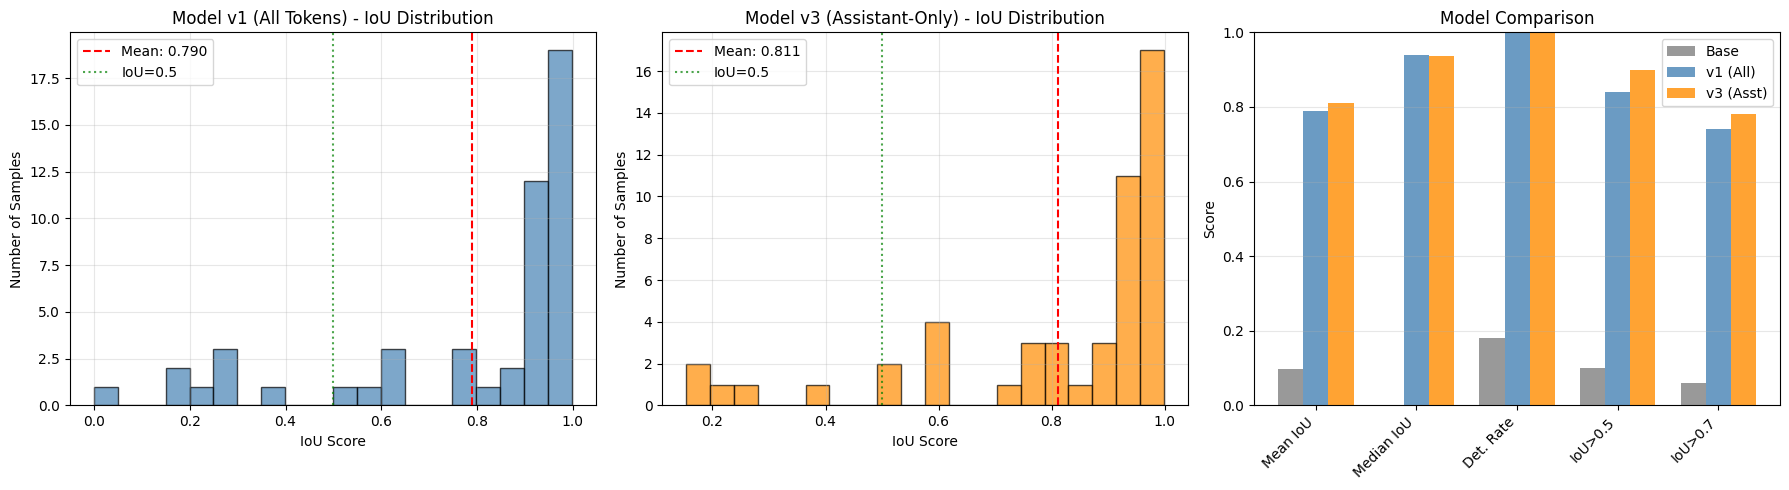

In [10]:
# Compare v1 vs v2 IoU distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# IoU histogram for Model v1
axes[0].hist(ious_v1, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(metrics_v1['mean_iou'], color='red', linestyle='--',
                label=f"Mean: {metrics_v1['mean_iou']:.3f}")
axes[0].axvline(0.5, color='green', linestyle=':', alpha=0.7, label='IoU=0.5')
axes[0].set_xlabel('IoU Score')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Model v1 (All Tokens) - IoU Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IoU histogram for Model v2
axes[1].hist(ious_v2, bins=20, edgecolor='black', alpha=0.7, color='darkorange')
axes[1].axvline(metrics_v2['mean_iou'], color='red', linestyle='--',
                label=f"Mean: {metrics_v2['mean_iou']:.3f}")
axes[1].axvline(0.5, color='green', linestyle=':', alpha=0.7, label='IoU=0.5')
axes[1].set_xlabel('IoU Score')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Model v2 (Assistant-Only) - IoU Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Comparison bar chart: v1 vs v2 vs base (if available)
metrics_names = ['Mean IoU', 'Median IoU', 'Det. Rate', 'IoU>0.5', 'IoU>0.7']
v1_values = [
    metrics_v1['mean_iou'],
    metrics_v1['median_iou'],
    metrics_v1['detection_rate'],
    metrics_v1['iou_threshold_0.5'],
    metrics_v1['iou_threshold_0.7']
]
v2_values = [
    metrics_v2['mean_iou'],
    metrics_v2['median_iou'],
    metrics_v2['detection_rate'],
    metrics_v2['iou_threshold_0.5'],
    metrics_v2['iou_threshold_0.7']
]

x = np.arange(len(metrics_names))
width = 0.25

if metrics_base:
    base_values = [
        metrics_base['mean_iou'],
        metrics_base['median_iou'],
        metrics_base['detection_rate'],
        metrics_base['iou_threshold_0.5'],
        metrics_base['iou_threshold_0.7']
    ]
    axes[2].bar(x - width, base_values, width, label='Base', alpha=0.8, color='gray')
    axes[2].bar(x, v1_values, width, label='v1 (All)', alpha=0.8, color='steelblue')
    axes[2].bar(x + width, v2_values, width, label='v2 (Asst)', alpha=0.8, color='darkorange')
else:
    axes[2].bar(x - width/2, v1_values, width, label='v1 (All Tokens)', alpha=0.8, color='steelblue')
    axes[2].bar(x + width/2, v2_values, width, label='v2 (Assistant-Only)', alpha=0.8, color='darkorange')

axes[2].set_ylabel('Score')
axes[2].set_title('Model Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 8. Visualize Predictions

Show example predictions comparing ground truth vs model predictions.

In [11]:
from qwen_vl_utils import process_vision_info

def run_inference_single(model, processor, image, prompt="Detect the bounding box of the nutrition table."):
    """Run inference on a single image and return parsed bbox."""
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=128, do_sample=False)

    generated_ids_trimmed = [out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)[0]

    return output_text, parse_qwen_bbox_output(output_text)


Visualizing 5 predictions...
Drew ground truth bbox 1 for 'nutrition-table': [853, 2049, 2279, 2697]
Drew bbox in pixels for 'nutrition-table': [823, 2057, 2277, 2600]
Drew bbox in pixels for 'nutrition-table-small': [823, 2604, 2233, 2970]
Drew bbox in pixels for 'nutrition-table-small': [823, 3084, 1522, 3244]
Drew bbox in pixels for 'nutrition-table-small': [823, 3244, 1522, 3484]
Drew bbox in pixels for 'nutrition-table-small': [823, 3484, 1522, 3724]
Drew ground truth bbox 1 for 'nutrition-table': [649, 805, 1915, 1479]
Drew bbox in pixels for 'nutrition-table': [653, 812, 1911, 1351]
Drew bbox in pixels for 'nutrition-table': [653, 812, 1911, 1351]
Drew bbox in pixels for 'nutrition-table': [653, 812, 1911, 1351]
Drew bbox in pixels for 'nutrition-table': [653, 812, 1911, 1351]
Drew bbox in pixels for 'nutrition-table': [653, 812, 1911, 1351]
Drew ground truth bbox 1 for 'nutrition-table': [81, 274, 1877, 1371]
Drew bbox in pixels for 'nutrition-table': [62, 269, 1848, 1330]
Dre

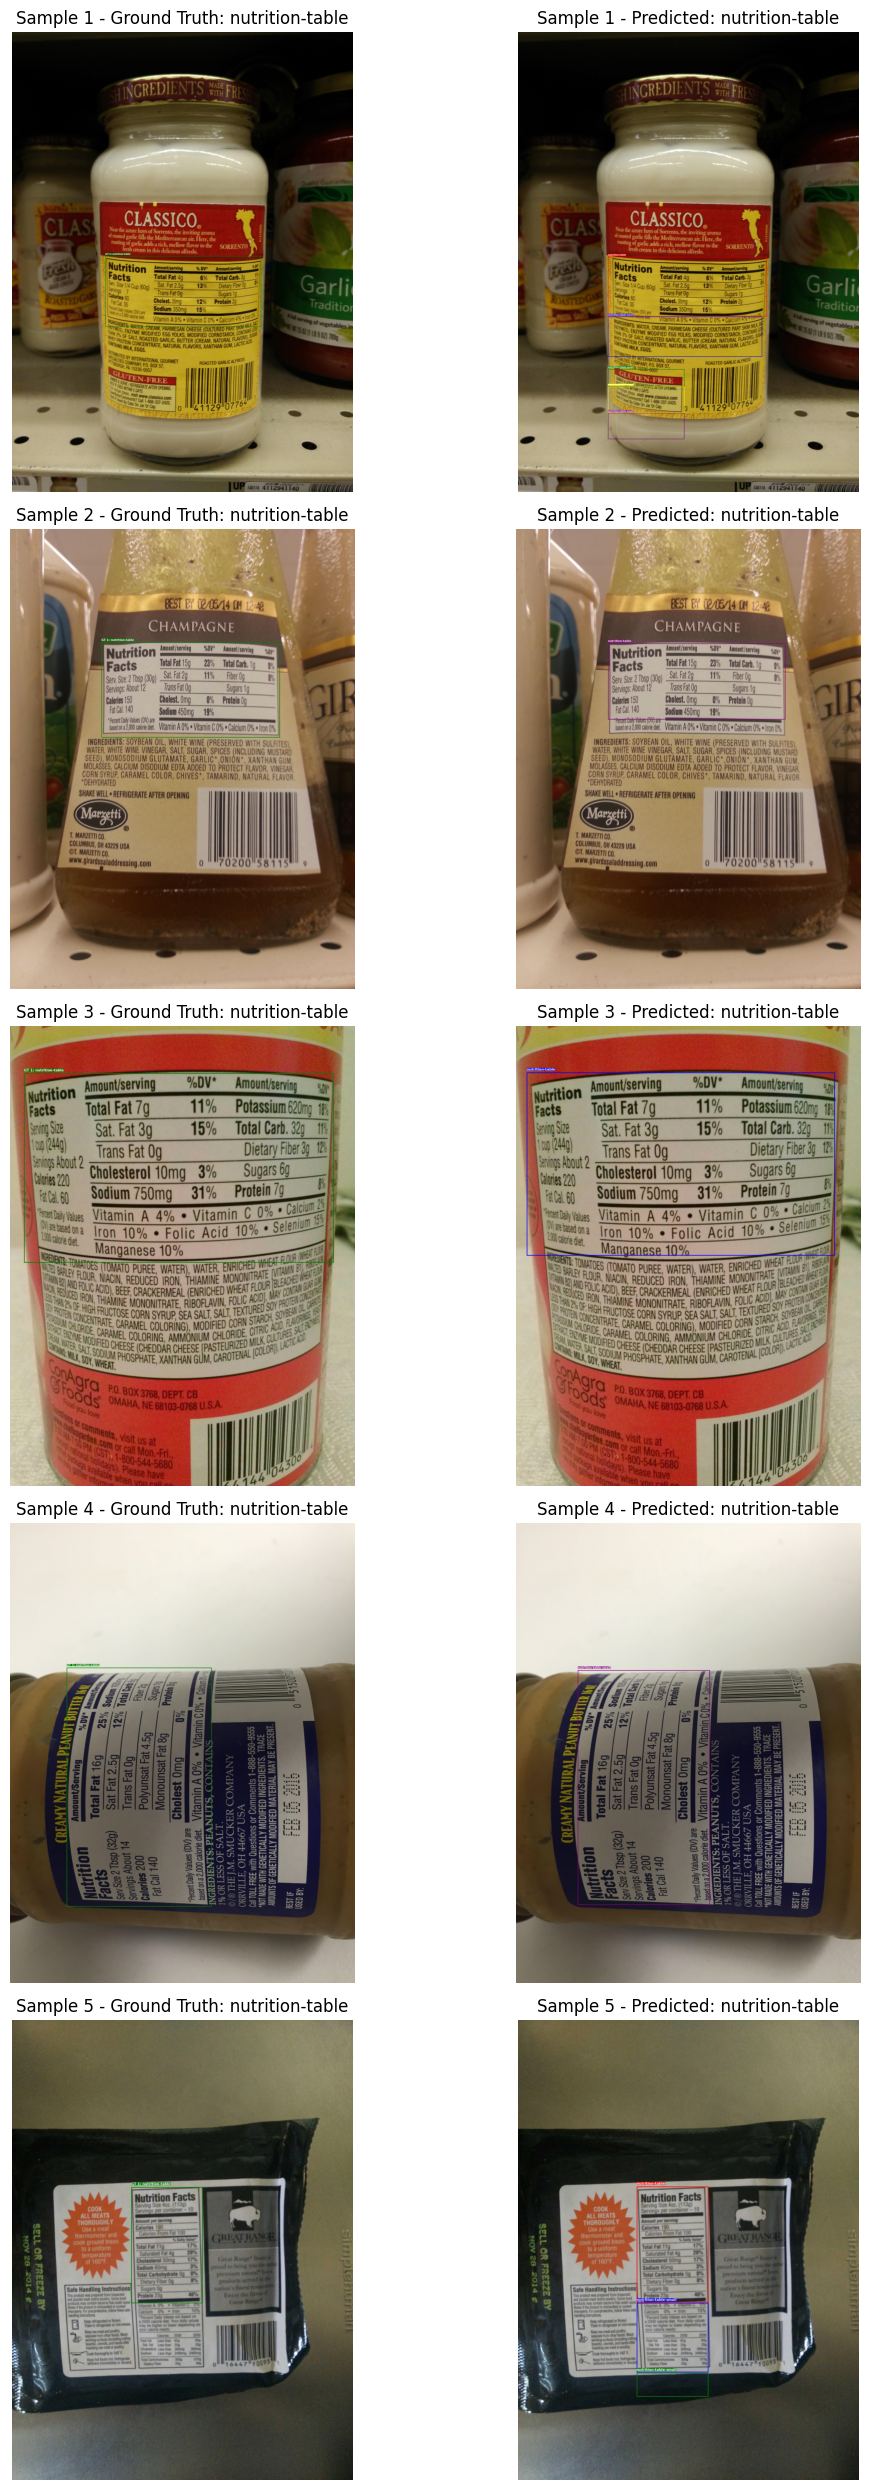

In [12]:
print(f"\nVisualizing {NUM_VISUALIZATION_SAMPLES} predictions...")

fig, axes = plt.subplots(NUM_VISUALIZATION_SAMPLES, 2, figsize=(12, 5*NUM_VISUALIZATION_SAMPLES))

for idx in range(NUM_VISUALIZATION_SAMPLES):
    example = eval_dataset[idx]
    image = example['image']
    gt_bbox = example['objects']['bbox'][0]
    gt_category = example['objects']['category_name'][0]

    # Run inference
    output_text, parsed_bbox = run_inference_single(model_finetuned, processor_finetuned, image)

    # Ground truth visualization
    img_gt = visualize_ground_truth_bbox(
        image,
        [gt_bbox],
        [gt_category],
        format='openfoodfacts'
    )

    # Prediction visualization
    if parsed_bbox:
        img_pred = visualize_bbox_on_image(image, parsed_bbox, normalize_coords=True)
        # Handle both single dict and list of dicts from parse_qwen_bbox_output
        if isinstance(parsed_bbox, list):
            pred_label = f"Predicted: {parsed_bbox[0].get('object', 'detected')}"
        else:
            pred_label = f"Predicted: {parsed_bbox.get('object', 'detected')}"
    else:
        img_pred = image.copy()
        pred_label = "No detection"

    # Plot
    axes[idx, 0].imshow(img_gt)
    axes[idx, 0].set_title(f"Sample {idx+1} - Ground Truth: {gt_category}")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(img_pred)
    axes[idx, 1].set_title(f"Sample {idx+1} - {pred_label}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

## 9. Analyze Failure Cases

Look at samples with low IoU to understand where the model struggles.

In [13]:
# Find failure cases (IoU < 0.5)
failure_threshold = 0.5
failure_indices = [i for i, iou in enumerate(ious_finetuned) if iou < failure_threshold]

print(f"\nFailure Analysis (IoU < {failure_threshold}):")
print(f"  Total failures: {len(failure_indices)} / {len(ious_finetuned)} ({100*len(failure_indices)/len(ious_finetuned):.1f}%)")

if failure_indices:
    print(f"\n  Failure case IoU scores:")
    for i, idx in enumerate(failure_indices[:10]):  # Show first 10
        print(f"    Sample {idx}: IoU = {ious_finetuned[idx]:.3f}")


Failure Analysis (IoU < 0.5):
  Total failures: 5 / 50 (10.0%)

  Failure case IoU scores:
    Sample 12: IoU = 0.153
    Sample 14: IoU = 0.197
    Sample 26: IoU = 0.176
    Sample 35: IoU = 0.271
    Sample 40: IoU = 0.394



Visualizing 3 failure cases...


Drew ground truth bbox 1 for 'nutrition-table-text': [1366, 311, 1670, 2787]
Drew bbox in pixels for 'nutrition-table-text': [1537, 652, 2115, 2434]
Drew bbox in pixels for 'nutrition-table-energy': [1542, 656, 1718, 786]
Drew bbox in pixels for 'nutrition-table-energy': [1539, 786, 1718, 917]
Drew bbox in pixels for 'nutrition-table-energy': [1539, 917, 1718, 1047]
Drew bbox in pixels for 'nutrition-table-energy': [1539, 1047, 1718, 1178]
Drew ground truth bbox 1 for 'nutrition-table-small-energy': [1723, 798, 1807, 979]
Drew bbox in pixels for 'nutrition-table': [1602, 733, 1788, 1032]
Drew bbox in pixels for 'nutrition-table-small-energy': [1726, 975, 1770, 1026]
Drew bbox in pixels for 'nutrition-table-small-energy': [1726, 936, 1770, 987]
Drew bbox in pixels for 'nutrition-table-small-energy': [1726, 1029, 1770, 1080]
Drew bbox in pixels for 'nutrition-table-small-energy': [1726, 985, 1770, 1036]
Drew ground truth bbox 1 for 'nutrition-table-text': [165, 1465, 1100, 1556]
Drew bbo

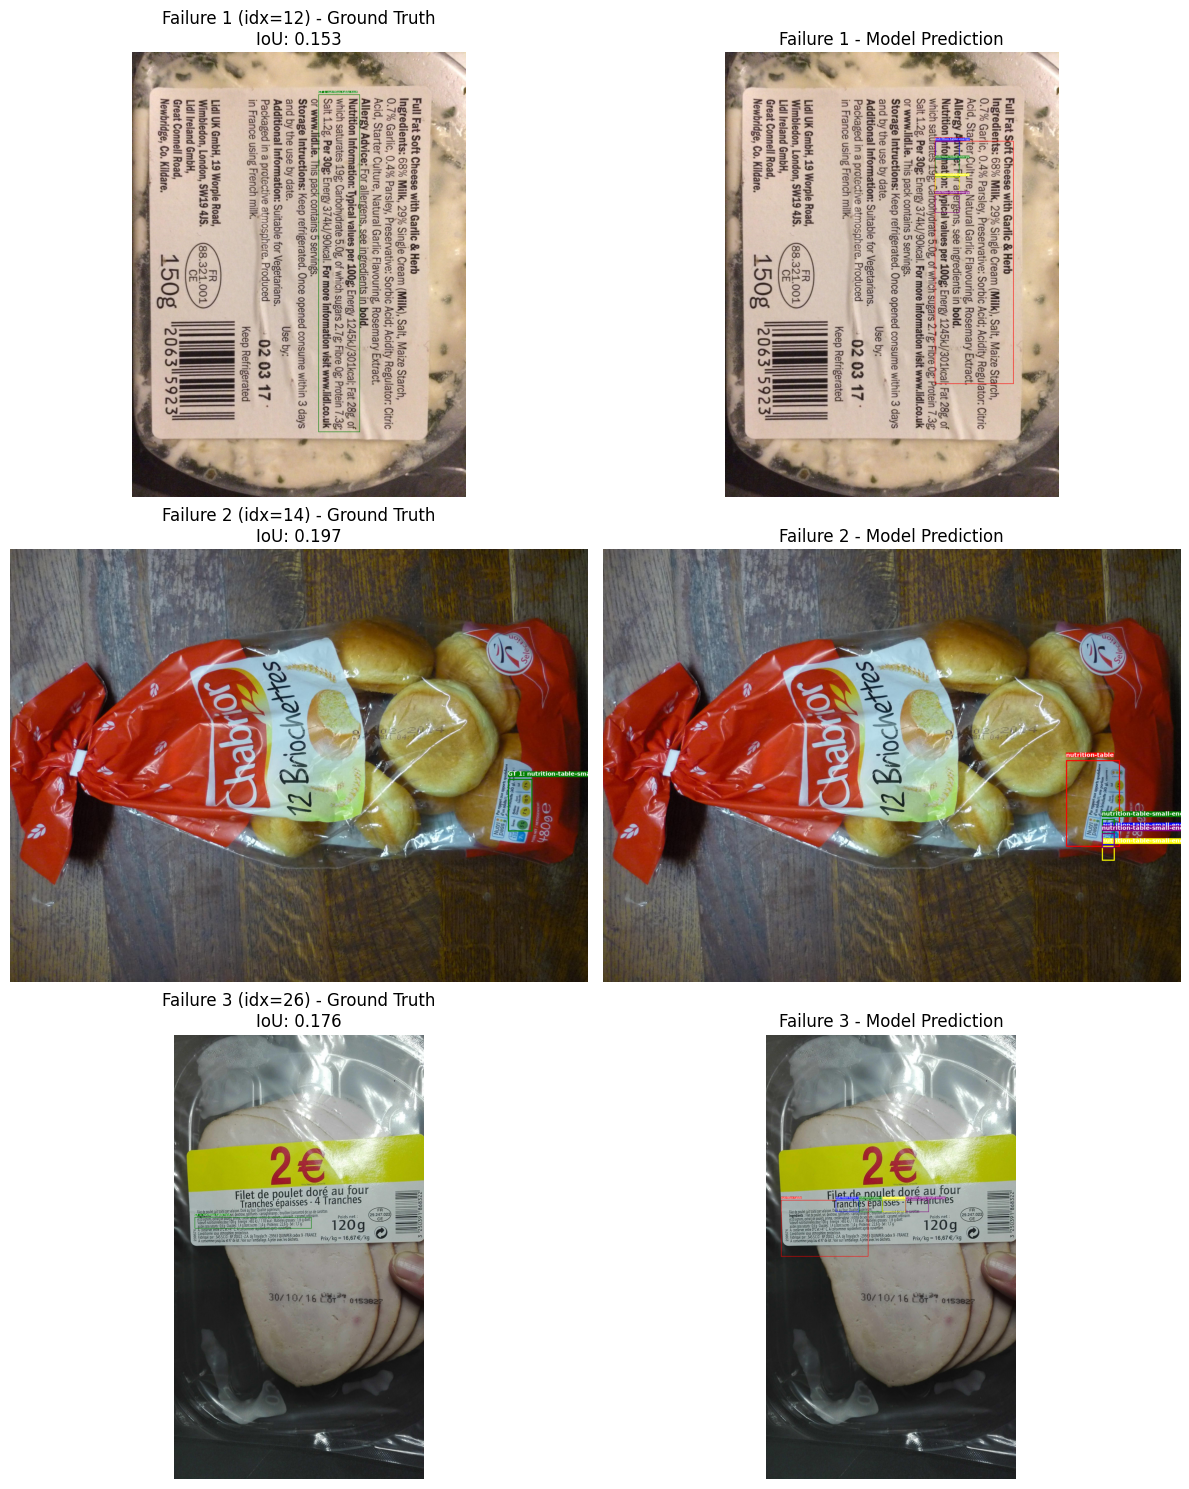

In [14]:
# Visualize a few failure cases
NUM_FAILURE_VIS = min(3, len(failure_indices))

if NUM_FAILURE_VIS > 0:
    print(f"\nVisualizing {NUM_FAILURE_VIS} failure cases...")

    fig, axes = plt.subplots(NUM_FAILURE_VIS, 2, figsize=(12, 5*NUM_FAILURE_VIS))
    if NUM_FAILURE_VIS == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(failure_indices[:NUM_FAILURE_VIS]):
        example = eval_dataset[idx]
        image = example['image']
        gt_bbox = example['objects']['bbox'][0]
        gt_category = example['objects']['category_name'][0]

        # Run inference
        output_text, parsed_bbox = run_inference_single(model_finetuned, processor_finetuned, image)

        # Ground truth
        img_gt = visualize_ground_truth_bbox(image, [gt_bbox], [gt_category], format='openfoodfacts')

        # Prediction
        if parsed_bbox:
            img_pred = visualize_bbox_on_image(image, parsed_bbox, normalize_coords=True)
        else:
            img_pred = image.copy()

        axes[i, 0].imshow(img_gt)
        axes[i, 0].set_title(f"Failure {i+1} (idx={idx}) - Ground Truth\nIoU: {ious_finetuned[idx]:.3f}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img_pred)
        axes[i, 1].set_title(f"Failure {i+1} - Model Prediction")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No failure cases to visualize!")

## 10. Summary

Print final summary of evaluation results.

In [15]:
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)

print(f"\nEvaluated on: {NUM_EVAL_SAMPLES} samples")

print(f"\n{'='*70}")
print(f"{'Model':<30} {'Mean IoU':>10} {'Det Rate':>10} {'IoU>0.5':>10} {'IoU>0.7':>10}")
print(f"{'='*70}")

if metrics_base:
    print(f"{'Base (No Fine-tuning)':<30} {metrics_base['mean_iou']:>10.4f} {metrics_base['detection_rate']:>10.2%} {metrics_base['iou_threshold_0.5']:>10.2%} {metrics_base['iou_threshold_0.7']:>10.2%}")

print(f"{'v1 (All Tokens)':<30} {metrics_v1['mean_iou']:>10.4f} {metrics_v1['detection_rate']:>10.2%} {metrics_v1['iou_threshold_0.5']:>10.2%} {metrics_v1['iou_threshold_0.7']:>10.2%}")
print(f"{'v2 (Assistant-Only)':<30} {metrics_v2['mean_iou']:>10.4f} {metrics_v2['detection_rate']:>10.2%} {metrics_v2['iou_threshold_0.5']:>10.2%} {metrics_v2['iou_threshold_0.7']:>10.2%}")

print(f"{'='*70}")

# Determine winner
v1_better = metrics_v1['mean_iou'] > metrics_v2['mean_iou']
winner = "v1 (All Tokens)" if v1_better else "v2 (Assistant-Only)"
diff = abs(metrics_v1['mean_iou'] - metrics_v2['mean_iou'])

print(f"\nBest Model: {winner}")
print(f"  Margin: {diff:.4f} IoU difference")

if metrics_base:
    best_iou = max(metrics_v1['mean_iou'], metrics_v2['mean_iou'])
    improvement = best_iou - metrics_base['mean_iou']
    print(f"\nImprovement over Base Model:")
    print(f"  Mean IoU: +{improvement:.4f} ({100*improvement/max(metrics_base['mean_iou'], 0.001):.1f}%)")

print("\n" + "="*70)


EVALUATION SUMMARY

Evaluated on: 50 samples

Model                            Mean IoU   Det Rate    IoU>0.5    IoU>0.7
Base (No Fine-tuning)              0.0981     18.00%     10.00%      6.00%
v1 (All Tokens)                    0.7897    100.00%     84.00%     74.00%
v3 (Assistant-Only)                0.8113    100.00%     90.00%     78.00%

Best Model: v3 (Assistant-Only)
  Margin: 0.0216 IoU difference

Improvement over Base Model:
  Mean IoU: +0.7131 (726.7%)



## Next Steps

Based on these results, you might consider:

1. **If IoU is low**:
   - Train for more epochs
   - Adjust learning rate
   - Check data quality

2. **If detection rate is low**:
   - Model might not be learning the task format
   - Check collator is working correctly

3. **If both are good**:
   - Merge LoRA weights for faster inference
   - Deploy with vLLM or similar